In [65]:
import torch
from torch import nn
from src.data import get_data
from src.models import get_encoder, get_decoder
from src.utils import softclip
from src.hessian import sampler
import yaml
from copy import deepcopy
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
import os


def get_model(encoder, decoder):
    
    net = deepcopy(encoder.encoder._modules)
    decoder = decoder.decoder._modules
    max_ = max([int(i) for i in net.keys()])
    for i in decoder.keys():
        net.update({f"{max_+int(i) + 1}": decoder[i]})

    return nn.Sequential(net)

In [6]:
path="../weights/mnist/lae_model_selection_7_may/weights_mnist_model_selection/1[backend_layer]_[approximation_exact]_[no_conv_True]_[train_samples_1]_"
with open(f"{path}/config.yaml") as file:
    config = yaml.full_load(file)
lae_encoder = get_encoder(config, latent_size=2)
lae_decoder = get_decoder(config, latent_size=2)
lae_net = get_model(lae_encoder, lae_decoder).eval()
lae_net.load_state_dict(torch.load(f"{path}/net.pth"))
hessian_approx = (
    sampler.BlockSampler()
    if config["approximation"] == "block"
    else sampler.DiagSampler()
)
h = torch.load(f"{path}/hessian.pth")
sigma_q = hessian_approx.invert(h).cpu()


In [8]:
_, val_dataloader = get_data("mnist")
images, labels = [ ], [ ]

for batch in val_dataloader:
    x, y = batch
    images.append(x)
    labels.append(y)
images = torch.cat(images, 0)
labels = torch.cat(labels, 0)

In [28]:
z_grid = torch.stack(torch.meshgrid(torch.linspace(-5, 5, 50), torch.linspace(-5, 5, 50))).reshape(2, -1).T

def get_encoding_lae(data, n=1, layer=5):
    embeddings = [ ]
    def fw_hook_get_latent(module, input, output):
        embeddings.append(output.detach().cpu())
    temp = deepcopy(lae_net)
    temp[layer].register_forward_hook(fw_hook_get_latent)

    mu_q = parameters_to_vector(temp.parameters())
    sample = hessian_approx.sample(mu_q, sigma_q, n_samples=n)
    for i in range(n):
        vector_to_parameters(sample[i], temp.parameters())
        _ = temp(data)
    return torch.cat(embeddings, 0)

decoded = lae_decoder(z_grid)
mean = torch.stack([get_encoding_lae(decoded) for _ in range(10)], 0).mean(0)
std = torch.stack([get_encoding_lae(decoded) for _ in range(10)], 0).std(0)

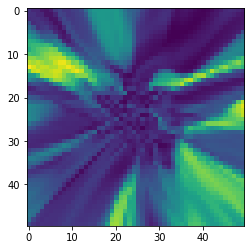

In [39]:
plt.imshow(std.reshape(50, 50, 2).sum(dim=-1))

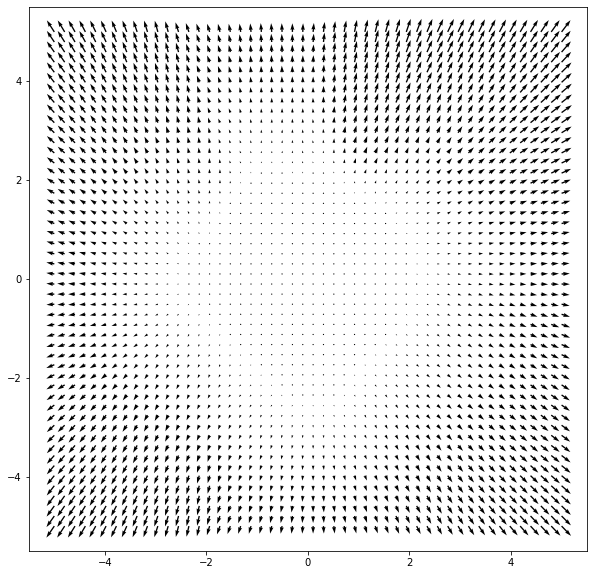

In [50]:
plt.figure(figsize=(10,10))
plt.quiver(z_grid[:,0], z_grid[:, 1], (z_grid - mean)[:,0], (z_grid - mean)[:,1])   


(array([ 41.,  69., 125., 144., 118., 166., 168., 139., 127.,  93.,  74.,
         76.,  85.,  93.,  54.,  56.,  49.,  40.,  24.,  34.,  30.,  27.,
         34.,  38.,  21.,  36.,  55.,  38.,  26.,  27.,  25.,  31.,  43.,
         27.,  25.,  34.,  22.,  33.,  30.,  30.,  24.,  10.,  10.,  12.,
         12.,  10.,   8.,   2.,   4.,   1.]),
 array([0.03725146, 0.05526024, 0.07326902, 0.09127779, 0.10928657,
        0.12729535, 0.14530413, 0.16331291, 0.18132168, 0.19933046,
        0.21733925, 0.23534802, 0.25335678, 0.27136558, 0.28937435,
        0.30738312, 0.32539192, 0.3434007 , 0.36140946, 0.37941825,
        0.39742702, 0.4154358 , 0.4334446 , 0.45145336, 0.46946213,
        0.48747092, 0.5054797 , 0.52348846, 0.54149723, 0.55950606,
        0.5775148 , 0.5955236 , 0.61353236, 0.63154113, 0.6495499 ,
        0.6675587 , 0.6855675 , 0.70357627, 0.72158504, 0.7395938 ,
        0.7576026 , 0.7756114 , 0.79362017, 0.81162894, 0.8296377 ,
        0.8476465 , 0.86565524, 0.8836641 , 0.

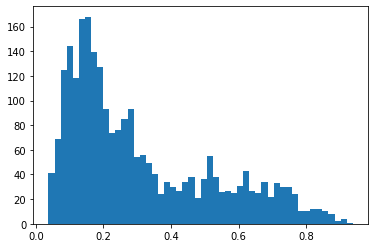

In [61]:
plt.hist(std.sum(1).numpy(), bins=50)

(array([ 58.,  81., 150., 204., 195., 156., 143., 102.,  82.,  86.,  85.,
         76.,  65.,  66.,  76., 103.,  91.,  76.,  83.,  44.,  38.,  45.,
         39.,  38.,  34.,  24.,  24.,  19.,  15.,  16.,  16.,  11.,  11.,
         16.,  11.,   9.,  10.,   9.,   8.,   3.,   9.,  22.,  12.,   7.,
          8.,   9.,   7.,   2.,   3.,   3.]),
 array([0.0432525 , 0.06640842, 0.08956435, 0.11272027, 0.1358762 ,
        0.1590321 , 0.18218803, 0.20534395, 0.22849987, 0.2516558 ,
        0.2748117 , 0.29796764, 0.32112357, 0.3442795 , 0.3674354 ,
        0.39059132, 0.41374725, 0.43690318, 0.4600591 , 0.48321503,
        0.50637096, 0.5295269 , 0.5526828 , 0.5758387 , 0.5989946 ,
        0.62215054, 0.64530647, 0.6684624 , 0.6916183 , 0.71477425,
        0.7379302 , 0.7610861 , 0.78424203, 0.80739796, 0.8305538 ,
        0.85370976, 0.8768657 , 0.9000216 , 0.92317754, 0.94633347,
        0.9694894 , 0.9926453 , 1.0158012 , 1.0389571 , 1.062113  ,
        1.085269  , 1.1084249 , 1.1315808 , 1.

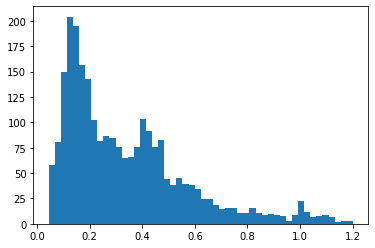

In [64]:
std = torch.stack([get_encoding_lae(decoded) for _ in range(10)], 0).std(0)
plt.hist(std.sum(1).numpy(), bins=50)